<a href="https://colab.research.google.com/github/lukechang93-ucla/MAE-263F/blob/main/Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [281]:
import numpy as np
import matplotlib.pyplot as plt

# Nodes & Properties FILES

In [282]:
%%writefile nodes.txt
0, 0
1, 0
2, 0
1, -1

Overwriting nodes.txt


In [283]:
%%writefile springs.txt
0, 1, 10
1, 2, 20
0, 3, 5
2, 3, 5

Overwriting springs.txt


# Nodes, springs, & properties READ

In [284]:
nodes_file_path = 'nodes.txt'
node_coordinates = []

try:
    with open(nodes_file_path, 'r') as f:
        for line in f:
            # Split each line by comma and remove leading/trailing whitespace
            parts = [part.strip() for part in line.split(',')]
            # Assuming the format is node number, x, y
            # We only need x and y, which are the second and third elements (index 1 and 2)
            if len(parts) == 2:
                try:
                    x = float(parts[0])
                    y = float(parts[1])
                    node_coordinates.append([x, y])
                except ValueError:
                    print(f"Skipping line due to non-numeric coordinates: {line.strip()}")
            else:
                print(f"Skipping line due to incorrect format: {line.strip()}")

    # Convert the list of coordinates to a NumPy array
    node_matrix = np.array(node_coordinates)

    print("Node coordinates successfully loaded into a numpy matrix.")
    display(node_matrix)

except FileNotFoundError:
    print(f"Error: The file '{nodes_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Node coordinates successfully loaded into a numpy matrix.


array([[ 0.,  0.],
       [ 1.,  0.],
       [ 2.,  0.],
       [ 1., -1.]])

In [285]:
springs_file_path = 'springs.txt'
index_info = []
stiffness_info = []

try:
    with open(springs_file_path, 'r') as f:
        for line in f:
            # Split each line by comma and remove leading/trailing whitespace
            parts = [part.strip() for part in line.split(',')]
            # Assuming the format is spring number, first node, second node, stiffness
            if len(parts) == 3:
                try:
                    first_node_index = int(parts[0])
                    second_node_index = int(parts[1])
                    stiffness = float(parts[2])
                    index_info.append([2*first_node_index, 2*first_node_index+1, 2*second_node_index, 2*second_node_index+1])
                    stiffness_info.append(stiffness)
                except ValueError:
                    print(f"Skipping line due to non-numeric coordinates: {line.strip()}")
            else:
                print(f"Skipping line due to incorrect format: {line.strip()}")

    # Convert the list of coordinates to a NumPy array
    index_matrix = np.array(index_info)
    stiffness_matrix = np.array(stiffness_info)

    print("Spring indices successfully loaded into a numpy matrix.")
    display(index_matrix)

    print("Spring stiffnesses successfully loaded into a numpy matrix.")
    display(stiffness_matrix)

except FileNotFoundError:
    print(f"Error: The file '{springs_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Spring indices successfully loaded into a numpy matrix.


array([[0, 1, 2, 3],
       [2, 3, 4, 5],
       [0, 1, 6, 7],
       [4, 5, 6, 7]])

Spring stiffnesses successfully loaded into a numpy matrix.


array([10., 20.,  5.,  5.])

# Gradients & Hessians DEFINITION

In [286]:
def gradEs(xk, yk, xkp1, ykp1, l_k, k):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.
    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * k * l_k * F  # Scale by k and l_k

    return F

In [287]:
def hessEs(xk, yk, xkp1, ykp1, l_k, k):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * k * l_k

    return J

# Equations of Motion & Jacobian DEFINITION

In [288]:
def getExternalForce(m):
  W = np.zeros_like(m)
  for i in range(len(m) // 2): # Go over every node. Size of m is 2 times node number
    W[2 * i] = 0.0 # x-coordinate
    W[2 * i + 1] = -9.81 * m[2 * i + 1] # y-coordinate
  return W

In [289]:
def getForceJacobian(x_new, x_old, u_old, stiffness_matrix, index_matrix, m, dt, l_k):
  ndof = x_new.shape[0] # Number of DOFs

  # Inertia
  f_inertia = m / dt * ((x_new - x_old) / dt - u_old)
  J_inertia = np.diag(m) / dt ** 2

  # Spring
  f_spring = np.zeros(ndof)
  J_spring = np.zeros((ndof, ndof))
  # Loop over each spring
  for i in range(stiffness_matrix.shape[0]):
    ind = index_matrix[i].astype(int)
    xi = x_new[ind[0]]
    yi = x_new[ind[1]]
    xj = x_new[ind[2]]
    yj = x_new[ind[3]]
    stiffness = stiffness_matrix[i]
    dF = gradEs(xi, yi, xj, yj, l_k[i], stiffness)
    dJ = hessEs(xi, yi, xj, yj, l_k[i], stiffness)
    f_spring[ind] += dF
    J_spring[np.ix_(ind,ind)] += dJ

  # External force
  f_ext = getExternalForce(m)
  J_ext = np.zeros((ndof, ndof))

  f = f_inertia + f_spring - f_ext
  J = J_inertia + J_spring - J_ext

  return f, J

In [290]:
def getInternalForceExplicit(x_old, stiffness_matrix, index_matrix, m, l_k):
  ndof = x_new.shape[0] # Number of DOFs

  # Spring
  f_spring = np.zeros(ndof)

  # Loop over each spring
  for i in range(stiffness_matrix.shape[0]):
    ind = index_matrix[i].astype(int)
    xi = x_new[ind[0]]
    yi = x_new[ind[1]]
    xj = x_new[ind[2]]
    yj = x_new[ind[3]]
    stiffness = stiffness_matrix[i]
    dF = gradEs(xi, yi, xj, yj, l_k[i], stiffness)
    f_spring[ind] += dF

  # External force
  f_ext = getExternalForce(m)
  f = f_spring - f_ext

  return f

# INTEGRATOR(s)

In [291]:
def myInt(t_new, x_old, u_old, free_DOF, stiffness_matrix, index_matrix, m, dt, l_k):
  # t_new is optional for debugging
  # It should calculate x_new and u_new knowing old positions and velocities
  # free_DOF is a vector containing the indices of free variables (not boundary)

  # Guess
  x_new = x_old.copy()

  eps = 1.0e-6 # not a good practice -- tolerance
  err = 10 * eps
  # Newton - Raphson
  while err > eps:
    f, J = getForceJacobian(x_new, x_old, u_old, stiffness_matrix, index_matrix, m, dt, l_k)

    # Extract free DOFs
    f_free = f[free_DOF]
    J_free = J[np.ix_(free_DOF, free_DOF)]

    # Solve for the correction (Delta x)
    deltaX_free = np.linalg.solve(J_free, f_free) # Most time consuming step and can be optimized using the sparsity/banded nature of the jacobian
    # PARDISO Project

    # Full deltaX
    deltaX = np.zeros_like(x_new)
    deltaX[free_DOF] = deltaX_free # Only update the free part

    # Update x_new
    x_new = x_new - deltaX

    # Calculate error
    err = np.linalg.norm(f_free)

  u_new = (x_new - x_old) / dt

  return x_new, u_new

In [292]:
def myIntExplicit(t_new, x_old, u_old, free_DOF, stiffness_matrix, index_matrix, m, dt, l_k):
  f = getInternalForceExplicit(x_old, stiffness_matrix, index_matrix, m, l_k)
  a_old = np.zeros_like(x_old)
  a_old = f / m
  u_new[free_DOF] = u_old[free_DOF] + dt * a_old[free_DOF]
  x_new[free_DOF] = x_old[free_DOF] + dt * a_old[free_DOF]

  return x_new, u_new

# Plot DEFINITION

In [293]:
def plot(x, index_matrix, t):
  plt.figure()
  plt.title(f'Time: {t:.2f} second')
  for i in range(index_matrix.shape[0]): # All springs
    ind = index_matrix[i].astype(int)
    xi = x[ind[0]]
    yi = x[ind[1]]
    xj = x[ind[2]]
    yj = x[ind[3]]

    plt.plot([xi, xj], [yi, yj], 'ko-')

  plt.axis('equal')
  plt.xlabel('x [meter]')
  plt.ylabel('y [meter]')
  plt.show()

# MAIN

**t = 0 Preparation**

In [294]:
N = node_matrix.shape[0] # Number of nodes
ndof = 2 * N # Number of degrees of freedom

# Initialize my positions and velocities (x_old and u_old; potentially a_old if using Newmark-Beta)
x_old = np.zeros(ndof)
u_old = np.zeros(ndof) # No need to update

# Build x_old vector from the nodes.txt file (node_matrix)
for i in range(N):
  x_old[2 * i] = node_matrix[i][0] # x coordinate
  x_old[2 * i + 1] = node_matrix[i][1] # y coordinate

# Every spring has a rest length
l_k = np.zeros_like(stiffness_matrix)
for i in range(stiffness_matrix.shape[0]):
    ind = index_matrix[i].astype(int)
    xi = x_old[ind[0]]
    yi = x_old[ind[1]]
    xj = x_old[ind[2]]
    yj = x_old[ind[3]]
    l_k[i] = np.sqrt((xj - xi) ** 2 + (yj - yi) ** 2)

# Mass
m = np.zeros(ndof)
for i in range(ndof):
  m[i] = 1.0 # In this problem, every point mass is 1 kg

**Simulation Loop**

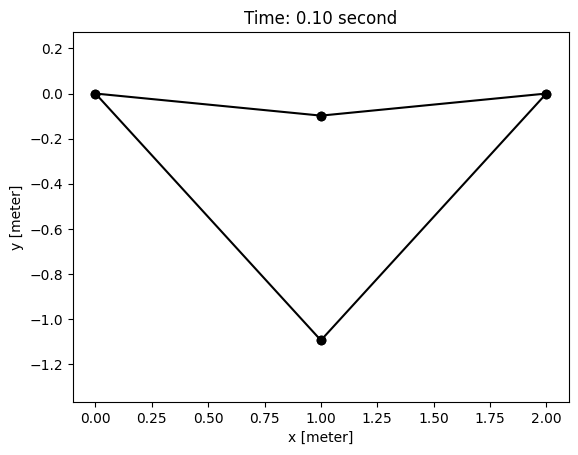

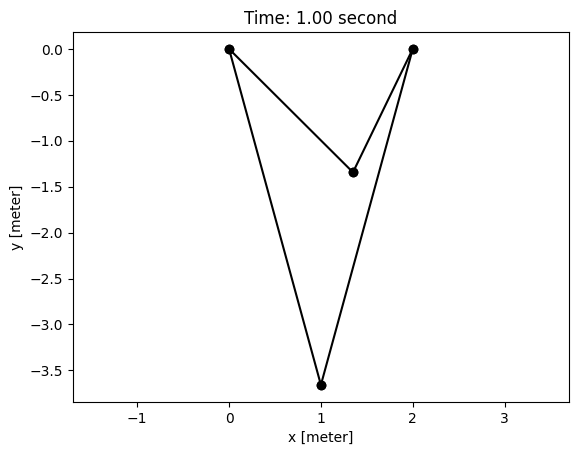

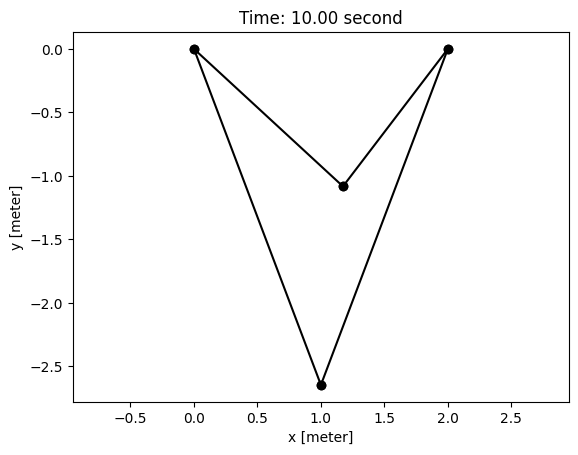

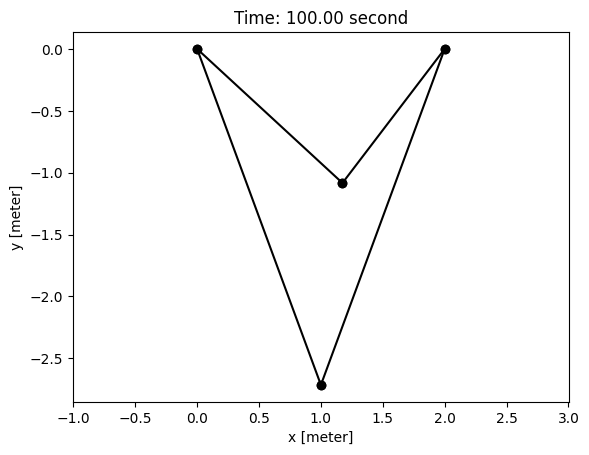

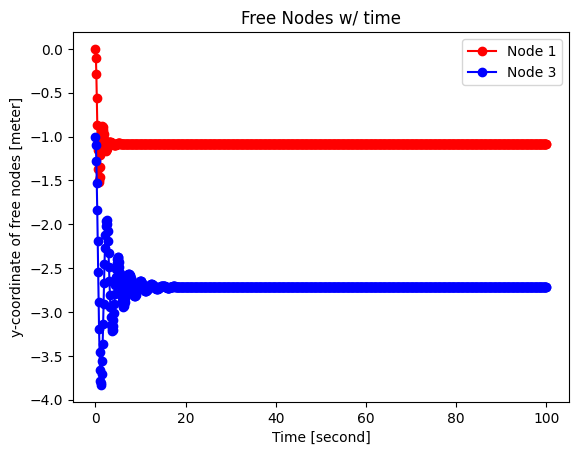

In [295]:
dt = 0.1 # time step size
maxTime = 100 # total time of simulation in seconds
t = np.arange(0, maxTime + dt, dt) # time array

# free DOFs
free_DOF = [2,3,6,7]

# Container to store the y-coordinate of the middle node
y1 = np.zeros(len(t))
y1[0] = x_old[3] # y coordinate of the second node
y2 = np.zeros(len(t))
y2[0] = x_old[7] # y coordinate of the second node

for k in range(len(t)-1):

  t_new = t[k+1] # Time

  # Call integrator
  x_new, u_new = myInt(t_new, x_old, u_old, free_DOF, stiffness_matrix, index_matrix, m, dt, l_k)

  #if k % 10 == 0:
  if t_new in [0, 0.1, 1, 10, 100]:
    plot(x_new, index_matrix, t_new)
  y1[k+1] = x_new[3] # y coordinate of second node
  y2[k+1] = x_new[7] # y coordinate of second node

  # Update x_old and u_old
  x_old = x_new
  u_old = u_new

# Plot free nodes
plt.figure()
plt.plot(t, y1, 'ro-', label = 'Node 1')
plt.plot(t, y2, 'bo-', label = 'Node 3')
plt.xlabel('Time [second]')
plt.ylabel('y-coordinate of free nodes [meter]')
plt.legend()
plt.title('Free Nodes w/ time')
plt.show()

**Explicit Simulation**

In [296]:
N = node_matrix.shape[0] # Number of nodes
ndof = 2 * N # Number of degrees of freedom

# Initialize my positions and velocities (x_old and u_old; potentially a_old if using Newmark-Beta)
x_old = np.zeros(ndof)
u_old = np.zeros(ndof) # No need to update

# Build x_old vector from the nodes.txt file (node_matrix)
for i in range(N):
  x_old[2 * i] = node_matrix[i][0] # x coordinate
  x_old[2 * i + 1] = node_matrix[i][1] # y coordinate

# Every spring has a rest length
l_k = np.zeros_like(stiffness_matrix)
for i in range(stiffness_matrix.shape[0]):
    ind = index_matrix[i].astype(int)
    xi = x_old[ind[0]]
    yi = x_old[ind[1]]
    xj = x_old[ind[2]]
    yj = x_old[ind[3]]
    l_k[i] = np.sqrt((xj - xi) ** 2 + (yj - yi) ** 2)

# Mass
m = np.zeros(ndof)
for i in range(ndof):
  m[i] = 1.0 # In this problem, every point mass is 1 kg

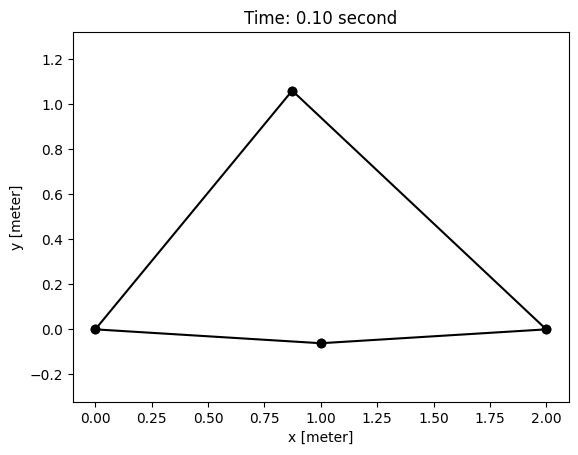

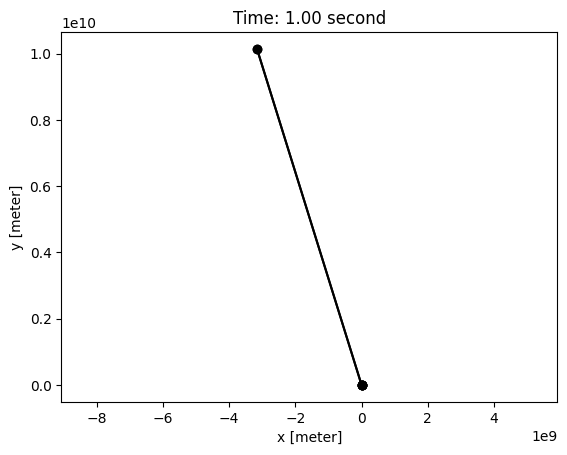

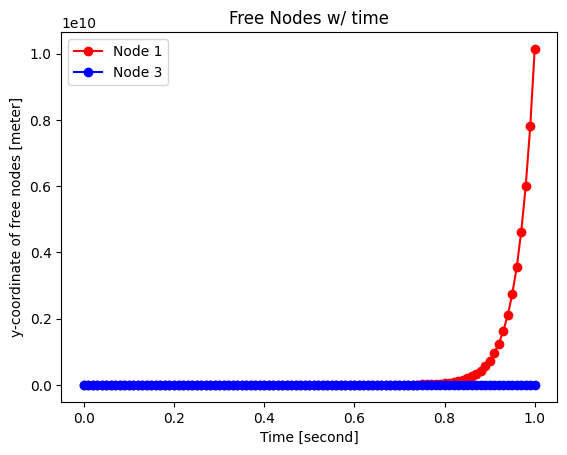

In [297]:
dt = 0.01 # time step size
maxTime = 1 # total time of simulation in seconds
t = np.arange(0, maxTime + dt, dt) # time array

# free DOFs
free_DOF = [2,3,6,7]

# Container to store the y-coordinate of the middle node
y1 = np.zeros(len(t))
y1[0] = x_old[3] # y coordinate of the second node
y2 = np.zeros(len(t))
y2[0] = x_old[7] # y coordinate of the second node

for k in range(len(t)-1):

  t_new = t[k+1] # Time

  # Call integrator
  x_new, u_new = myIntExplicit(t_new, x_old, u_old, free_DOF, stiffness_matrix, index_matrix, m, dt, l_k)

  #if k % 10 == 0:
  if t_new in [0, 0.1, 1, 10, 100]:
    plot(x_new, index_matrix, t_new)
  y1[k+1] = x_new[3] # y coordinate of second node
  y2[k+1] = x_new[7] # y coordinate of second node

  # Update x_old and u_old
  x_old = x_new
  u_old = u_new

# Plot free nodes
plt.figure()
plt.plot(t, y1, 'ro-', label = 'Node 1')
plt.plot(t, y2, 'bo-', label = 'Node 3')
plt.xlabel('Time [second]')
plt.ylabel('y-coordinate of free nodes [meter]')
plt.legend()
plt.title('Free Nodes w/ time')
plt.show()